## Muestreo

Para analizar la calidad del conjunto de datos, seleccionar variables, limpiar y transformar los datos y finalmente determinar un número $k$ de clusters partiremos de un muestreo del conjunto de datos inicial, con un tamaño de muestra del 3% con respecto al original. 

Para el muestreo utilizamos el método de __reservoir sapling__ visto en clase.

Como el conjunto de datos cuenta con más de 5 millones de registros, segun su [documentación](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3) fijamos el tamaño de muestra:




In [1]:
1

[1] 1

In [2]:
2

[1] 2

In [3]:
n_muestras <- 5.4*(1*10**6)*0.3
t1 <- Sys.time()
dir()
print(n_muestras)
set.seed(0)

[1] "Fire_Department_Calls_for_Service.csv"         
[2] "JessVega.ipynb"                                
[3] "muestra_Fire_Department_Calls_for_Service.csv" 
[4] "muestra3_Fire_Department_Calls_for_Service.csv"
[5] "tutorials"

[1] 1620000


In [4]:
path.file <- "Fire_Department_Calls_for_Service.csv" #--path donde se encuentra el conjunto de datos original 
n_filas_read <- 500000 # la rm nos permite cargar este numero de registros y agilizar el muestreo

connection <- file(path.file, open = "r")
#--nombre de las columnas (primera fila)
#col_names  <- read.csv(connection, nrows = 1, header = TRUE)
#--definimos nuestro buffer (muestra) y los rellenamos con las primeras n_muestras filas
buffer <- read.csv(connection, nrows = n_muestras, header = TRUE, stringsAsFactors = FALSE)

#--indice que nos permitira generar los numeros aleatorios correctamente
posicion_inicial <- n_muestras
random_unif <- function(x) sample.int(x,1)

contador <- 1
repeat{
  print(paste0("Posicion inicial: ", posicion_inicial))
  
   #--leemos una parte del archivo
  temp <- read.csv(connection, nrows = n_filas_read, header = FALSE)

  #--indices que controlan el maximo de cada numero aleatorio
  maximo <- c(1:nrow(temp)) + posicion_inicial

  #--generamos numeros aleatorios de forma vectorizada, segun esto solo permuta los indices
  j = vapply(maximo, random_unif, FUN.VALUE = integer(1))

  #--observamos cuales de los numeros aleatorios son menores que nuestra muestra
  idx <- j <= n_muestras

  #--sustituimos los que resultaron menores
  buffer[j[idx], ] <- temp[idx, ]
  
  print(paste0("iteracion: ", contador))
  contador <- contador + 1
  #--redefinimos la posicion inicial para la siguiente iteracion
  posicion_inicial <- posicion_inicial + nrow(temp)
  
  #--si el numero de filas leidas es menor que el esperado,
  #-asumimos que se acabo el archivo y salimos del ciclo
  if(nrow(temp) < n_filas_read)
    break
}
t2 <- Sys.time()
print(t2 - t1) #(Time difference of 9.29019 mins mins )
#--guardar nuestra muestra para un futuro analisis
write.csv(buffer, paste0("muestra_", path.file), row.names = FALSE )
close(connection)

[1] "Posicion inicial: 1620000"
[1] "iteracion: 1"
[1] "Posicion inicial: 2120000"
[1] "iteracion: 2"
[1] "Posicion inicial: 2620000"
[1] "iteracion: 3"
[1] "Posicion inicial: 3120000"
[1] "iteracion: 4"
[1] "Posicion inicial: 3620000"
[1] "iteracion: 5"
[1] "Posicion inicial: 4120000"
[1] "iteracion: 6"
[1] "Posicion inicial: 4620000"
[1] "iteracion: 7"
[1] "Posicion inicial: 5120000"
[1] "iteracion: 8"
Time difference of 8.008767 mins


In [5]:
library(readr)
data <- read_csv('muestra3_Fire_Department_Calls_for_Service.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  Call.Number = col_double(),
  Incident.Number = col_double(),
  Zipcode.of.Incident = col_double(),
  Final.Priority = col_double(),
  ALS.Unit = col_logical(),
  Number.of.Alarms = col_double(),
  Unit.sequence.in.call.dispatch = col_double(),
  Supervisor.District = col_double(),
  Supervisor.Districts = col_double(),
  Fire.Prevention.Districts = col_double(),
  Current.Police.Districts = col_double(),
  Neighborhoods...Analysis.Boundaries = col_double(),
  Zip.Codes = col_double(),
  Neighborhoods..old. = col_double(),
  Police.Districts = col_double(),
  Civic.Center.Harm.Reduction.Project.Boundary = col_double(),
  HSOC.Zones = col_double(),
  Central.Market.Tenderloin.Boundary.Polygon...Updated = col_double()
)

See spec(...) for full column specifications.

Warning message:
“2 parsing failures.
  row           col                     expected     actual                                             file
14142

In [6]:
print(dim(data))

[1] 14142    44


# Selección de variables 


Después de leer la documentación y entender la estructura de la data, decidimos que el cluster que realizaremos tendrá como objetivo encontrar grupos de llamadas parecidas entre sí y contrastaremos estos grupos con la etiqueta que poseen los datos en la columna `Call Type Group`.
Después de revisar la documentación  descartamos las columnas `Call.Type`, `RowID`, `Unit ID`, `Incident Number`, `Unit Type`, `Unit sequence in call dispatch` al igual que `Location`. Las primeras por no aportar información extra y la última porque la documentación no proporciona el tipo de proyección utilizado para referencias las coordenadas de los puntos.

In [7]:
data$RowID <- data$Unit.ID <- data$Incident.Number <- data$Location <- data$Unit.Type <- data$Unit.sequence.in.call.dispatch <- data$Call.Type <- NULL

In [8]:
names(data)

[1] "Call.Number"                                         
 [2] "Call.Date"                                           
 [3] "Watch.Date"                                          
 [4] "Received.DtTm"                                       
 [5] "Entry.DtTm"                                          
 [6] "Dispatch.DtTm"                                       
 [7] "Response.DtTm"                                       
 [8] "On.Scene.DtTm"                                       
 [9] "Transport.DtTm"                                      
[10] "Hospital.DtTm"                                       
[11] "Call.Final.Disposition"                              
[12] "Available.DtTm"                                      
[13] "Address"                                             
[14] "City"                                                
[15] "Zipcode.of.Incident"                                 
[16] "Battalion"                                           
[17] "Station.Area"                                        
[18] "Box"                                                 
[19] "Original.Priority"                                   
[20] "Priority"                                            
[21] "Final.Priority"                                      
[22] "ALS.Unit"                                            
[23] "Call.Type.Group"                                     
[24] "Number.of.Alarms"                                    
[25] "Fire.Prevention.District"                            
[26] "Supervisor.District"                                 
[27] "Neighborhooods...Analysis.Boundaries"                
[28] "Supervisor.Districts"                                
[29] "Fire.Prevention.Districts"                           
[30] "Current.Police.Districts"                            
[31] "Neighborhoods...Analysis.Boundaries"                 
[32] "Zip.Codes"                                           
[33] "Neighborhoods..old."                                 
[34] "Police.Districts"                                    
[35] "Civic.Center.Harm.Reduction.Project.Boundary"        
[36] "HSOC.Zones"                                          
[37] "Central.Market.Tenderloin.Boundary.Polygon...Updated"

En vista de que las siguientes columnas no se encuentran [documentadas en el diccionario de datos correspondiente](https://data.sfgov.org/api/views/nuek-vuh3/files/ddb7f3a9-0160-4f07-bb1e-2af744909294?download=true&filename=FIR-0002_DataDictionary_fire-calls-for-service.xlsx) procedemos a eliminarlas:
`Current Police Districts`, `Neighborhoods - Analysis Boundaries` , `Zip Codes`, `Neighborhoods (old)`, `Police Districts`, `Civic Center Harm Reduction Project Boundary`, `HSOC Zones` y  `Central Market/Tenderloin Boundary Polygon - Updated`

In [9]:
data[ , c('Current.Police.Districts', 'Neighborhoods...Analysis.Boundaries', 'Zip.Codes', 'Neighborhoods..old.', 'Police.Districts', 
          'Civic.Center.Harm.Reduction.Project.Boundary', 'HSOC.Zones', 'Central.Market.Tenderloin.Boundary.Polygon...Updated')] <- NULL

In [10]:
head(data)

Call.Number,Call.Date,Watch.Date,Received.DtTm,Entry.DtTm,Dispatch.DtTm,Response.DtTm,On.Scene.DtTm,Transport.DtTm,Hospital.DtTm,⋯,Priority,Final.Priority,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
70350005,02/04/2007,02/03/2007,02/04/2007 12:17:58 AM,02/04/2007 12:20:11 AM,02/04/2007 12:20:23 AM,02/04/2007 12:21:55 AM,NA,NA,NA,⋯,3,3,TRUE,NA,1,8,4,Sunset/Parkside,3,1
21020346,04/12/2002,04/12/2002,04/12/2002 06:25:34 PM,04/12/2002 06:26:58 PM,04/12/2002 06:27:07 PM,04/12/2002 06:29:09 PM,04/12/2002 06:29:41 PM,04/12/2002 06:33:44 PM,NA,⋯,3,3,TRUE,NA,1,6,9,Mission,7,2
192952215,10/22/2019,10/22/2019,10/22/2019 01:29:33 PM,10/22/2019 01:32:23 PM,10/22/2019 01:32:57 PM,10/22/2019 01:34:13 PM,10/22/2019 01:35:53 PM,NA,NA,⋯,3,3,FALSE,Alarm,1,9,11,Outer Mission,6,9
152393922,08/27/2015,08/27/2015,08/27/2015 09:35:37 PM,08/27/2015 09:36:26 PM,08/27/2015 09:41:36 PM,08/27/2015 09:42:44 PM,NA,NA,NA,⋯,3,3,FALSE,Alarm,1,1,2,Russian Hill,1,5
122590197,09/15/2012,09/15/2012,09/15/2012 03:06:15 PM,09/15/2012 03:08:54 PM,09/15/2012 03:09:14 PM,09/15/2012 03:10:02 PM,09/15/2012 03:18:19 PM,NA,NA,⋯,1,2,TRUE,Non Life-threatening,1,9,11,Excelsior,6,9
131650329,06/14/2013,06/14/2013,06/14/2013 07:14:10 PM,06/14/2013 07:16:17 PM,06/14/2013 07:16:35 PM,06/14/2013 07:16:46 PM,06/14/2013 07:20:39 PM,06/14/2013 07:39:44 PM,06/14/2013 07:55:31 PM,⋯,3,3,TRUE,Potentially Life-Threatening,1,4,6,Tenderloin,9,13


# Limpieza de datos 


Procedemos a retener el último registro de cada llamada, el cual contiene la información acumulada de los anteriores. 

In [11]:
library(dplyr)
library(lubridate)
data$Received.DtTm <- mdy_hms(data$Received.DtTm)
data %>% group_by(Call.Number ) %>% arrange(Call.Number , Received.DtTm ) %>% mutate( flag1 = n() ,flag2 = row_number()) -> data
data %>% filter(flag1 ==flag2 ) -> data
data$flag1 <- data$flag2 <- NULL
data$Available.DtTm <- NULL
data$Call.Date <- mdy(data$Call.Date)
data$Watch.Date <- mdy(data$Watch.Date)
data$Entry.DtTm <- mdy_hms(data$Entry.DtTm)
data$Dispatch.DtTm <- mdy_hms(data$Dispatch.DtTm)
data$Response.DtTm <- mdy_hms( data$Response.DtTm) 
data$On.Scene.DtTm <- mdy_hms( data$On.Scene.DtTm) 
data$Transport.DtTm <- mdy_hms(data$Transport.DtTm) 
data$Hospital.DtTm <- mdy_hms(data$Hospital.DtTm) 



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Warning message:
“ 1 failed to parse.”


Como suponemos que la duración de la llamada está correlacionada con su clasificación con las variables de tipo fecha (`Call.Date`, `Watch.Date`, `Received.DtTm`, `Entry.DtTm`, `Dispatch.DtTm`, `Response.DtTm`, `On.Scene.DtTm`, `Transport.DtTm`, `Hospital.DtTm`) obtenemos la duración aproximada de la llamada. 


In [12]:
head(data)

Call.Number,Call.Date,Watch.Date,Received.DtTm,Entry.DtTm,Dispatch.DtTm,Response.DtTm,On.Scene.DtTm,Transport.DtTm,Hospital.DtTm,⋯,Priority,Final.Priority,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts
<dbl>,<date>,<date>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,⋯,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1050067,2000-04-14,2000-04-14,2000-04-14 08:20:12,2000-04-14 08:21:03,2000-04-14 08:23:48,2000-04-14 08:24:20,2000-04-14 08:34:27,NA,NA,⋯,1,2,FALSE,NA,1,2,10,Potrero Hill,8,8
1050380,2000-04-14,2000-04-14,2000-04-14 23:46:31,2000-04-14 23:47:37,2000-04-14 23:48:06,2000-04-14 23:55:47,2000-04-14 23:59:50,NA,NA,⋯,3,3,TRUE,NA,1,3,6,Tenderloin,9,14
1060050,2000-04-15,2000-04-14,2000-04-15 06:01:11,2000-04-15 06:01:52,2000-04-15 06:02:13,2000-04-15 06:04:06,2000-04-15 06:05:24,NA,NA,⋯,3,3,TRUE,NA,1,4,6,Tenderloin,9,13
1060066,2000-04-15,2000-04-15,2000-04-15 08:10:42,2000-04-15 08:12:30,2000-04-15 08:13:47,2000-04-15 08:16:17,2000-04-15 08:18:57,NA,NA,⋯,3,3,FALSE,NA,1,9,11,Excelsior,6,9
1070035,2000-04-16,2000-04-15,2000-04-16 01:56:02,2000-04-16 01:57:19,2000-04-16 01:58:38,2000-04-16 02:00:12,2000-04-16 02:02:41,NA,NA,⋯,3,3,FALSE,NA,1,1,3,North Beach,10,3
1070156,2000-04-16,2000-04-16,2000-04-16 13:05:51,2000-04-16 13:06:15,2000-04-16 13:06:57,2000-04-16 13:09:40,2000-04-16 13:11:41,NA,NA,⋯,3,3,FALSE,NA,1,2,6,Tenderloin,9,7


In [13]:
install.packages('reshape2')
library(reshape2)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [14]:
data.t <- melt(data, id = c('Call.Number','Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 
                            'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 
                            'Number.of.Alarms',  'Fire.Prevention.District', 'Supervisor.District', 
                            'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts', 'Fire.Prevention.Districts' ) ) %>%
          filter( variable %in% c('Received.DtTm', 'Entry.DtTm', 'Dispatch.DtTm', 'Response.DtTm', 'On.Scene.DtTm', 'Transport.DtTm', 'Hospital.DtTm' )) 
head(data.t)

Warning message:
“attributes are not identical across measure variables; they will be dropped”


,Call.Number,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,⋯,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,variable,value
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<dbl>
1,1050067,Other,MARIPOSA ST/POTRERO AV,SF,94110,B02,29,5243,1,1,⋯,FALSE,NA,1,2,10,Potrero Hill,8,8,Received.DtTm,955700412
2,1050380,Other,TAYLOR ST/TURK ST,SF,94102,B03,01,1365,3,3,⋯,TRUE,NA,1,3,6,Tenderloin,9,14,Received.DtTm,955755991
3,1060050,Other,700 Block of GEARY ST,SF,94109,B04,03,1556,3,3,⋯,TRUE,NA,1,4,6,Tenderloin,9,13,Received.DtTm,955778471
4,1060066,Other,100 Block of PARIS ST,SF,94112,B09,43,6131,3,3,⋯,FALSE,NA,1,9,11,Excelsior,6,9,Received.DtTm,955786242
5,1070035,Other,500 Block of BROADWAY,SF,94133,B01,02,1311,3,3,⋯,FALSE,NA,1,1,3,North Beach,10,3,Received.DtTm,955850162
6,1070156,Other,200 Block of TURK ST,SF,94102,B03,01,1456,3,3,⋯,FALSE,NA,1,2,6,Tenderloin,9,7,Received.DtTm,955890351


In [15]:
data.t %>% group_by (Call.Number, Call.Final.Disposition, Address, City, Zipcode.of.Incident, Battalion, 
                            Station.Area, Box, Original.Priority, Priority, Final.Priority, ALS.Unit, Call.Type.Group, 
                            Number.of.Alarms,  Fire.Prevention.District, Supervisor.District, 
                            Neighborhooods...Analysis.Boundaries, Supervisor.Districts, Fire.Prevention.Districts  ) %>% 
      summarise( min.t = min(value, na.rm=TRUE), max.t =max(value, na.rm=TRUE)) -> data.t
data.t <- data.t %>% mutate(Call.seconds = max.t - min.t)
data.t$min.t <- data.t$max.t <- NULL 

`summarise()` regrouping output by 'Call.Number', 'Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 'Number.of.Alarms', 'Fire.Prevention.District', 'Supervisor.District', 'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts' (override with `.groups` argument)



In [16]:
print(dim(data.t))
tail(data.t)

[1] 14097    20


Call.Number,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,Final.Priority,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,Call.seconds
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
202540487,Code 2 Transport,1300 Block of STEVENSON ST,San Francisco,94103,B02,06,5126,A,2,2,TRUE,Non Life-threatening,1,2,6,Mission,9,8,2224
202541155,Code 2 Transport,600 Block of LINDEN ST,San Francisco,94102,B02,05,3423,3,3,3,FALSE,NA,1,2,5,Hayes Valley,11,7,2917
202542461,Code 2 Transport,1900 Block of 45TH AV,San Francisco,94116,B08,23,7663,B,2,2,TRUE,Non Life-threatening,1,8,4,Sunset/Parkside,3,1,4930
202560405,Code 2 Transport,200 Block of TAYLOR ST,San Francisco,94102,B03,03,1453,3,E,3,TRUE,Potentially Life-Threatening,1,3,6,Tenderloin,9,14,338
202570838,Fire,600 Block of VAN NESS AVE,San Francisco,94102,B02,05,3164,3,3,3,TRUE,Alarm,1,2,5,Western Addition,11,7,407
202570843,Code 2 Transport,MARINA BL/BRODERICK ST,San Francisco,94123,B04,16,4214,B,2,2,TRUE,Non Life-threatening,1,4,2,Marina,1,13,2456


# K-means on-line

Como aplicación principal de machine learning tenemos dos objetivos, el primero es encontrar grupos de llamadas similares entre sí y que estos se contrastarlos con la etiqueta de 4 tipos que la data tiene, el segundo es asignar un tipo de llamada a los que no la tienen razón que desconocemos pues la documentación del dataset no lo declara. 


In [17]:
alpha <- 0.1
data <- as.data.frame(data.t)
kmeans.online.b.init <- function(data, k, alpha){
  # clousure para distribuir la eleccion del elemento k
  data <- data
  alpha <- alpha
  function(k){
    # Entradas 
    # data (data.frame): Dataframe donde las observaciones son los elementos a clusterizar y las columnas son las variables
    # k (int): Numero de cluster requerido
    # alpha (numeric): learning rate
    # Salida
    # kmeans.online con los elementos:
    # tabla.master (data.frame): Dos columnas, la primera con el id de la observacion y la segunda con el label del cluster
    # statas.intra (vector): Vector con la media d ela varianza intraelementos
    tabla.master <- data.frame(Obs = row.names(data), Cluster= rep(-Inf, dim(data)[1]))
    # inicializacion alatoria entre el minimo y maximo de cada variable
    stats.min <- sapply(data, min, na.rm=TRUE)
    stats.max <- sapply(data, max, na.rm=TRUE)
    set.seed(0)
    centroides <- mapply(function(x, y) {runif(k, x, y)},  stats.min, stats.max) 
    # termina inicializacion de centroides
    
    # comienza kmeans proceso online
    
    for( i in 1:dim(data)[1])
    {
      #i <- 11
      #print(i)
      # comienza asignacion de cluster mas cercano
      observacion.en.juego <- as.matrix(data[i, ])
      m.temp <- as.matrix(rbind(observacion.en.juego, centroides))
      distancias <- dist(m.temp)
      m.distancias <- as.matrix(distancias)
      k.i <- which.min(m.distancias[1, 2:(k+1)])
      tabla.master$Cluster[i] <- k.i
      # termina asignacion de cluster mas cercano 
      # update de cluster
      centroides[k.i, ] <- centroides[k.i, ] + alpha*observacion.en.juego
    }
    stats <- rep(-Inf, k)
    for ( i in 1:k)
    {
      index <- which( tabla.master$Cluster == i)
      data.subset <- data[ index, ]
      stats.i <- dist(data.subset)
      stats[i] <- sum(stats.i) # asumimos independencia entre las variables
    }
    kmeans.online <- list( tabla.master =tabla.master, statas.intra = stats)
    return(kmeans.online)
  }
}

In [18]:
Y <- data.frame(y=data$Call.Type.Group)
row.names(Y) <- row.names(data) <- data$Call.Number
data$Call.Type.Group <- data$Call.Number <- NULL
# hacemos un cambio de encoding de las variables ordinales para no hacer una matriz con muchas variables ---IMPORTANTE

In [19]:
index <- which(is.na(Y$y))
Y$y <- as.character(Y$y) 
Y$y[index] <- 'No asignado'

In [20]:
index <- which(sapply(data, class) == 'character')
normalizar <- function(x, na.rm = FALSE) (x - mean(x, na.rm = na.rm)) / sd(x, na.rm)

In [21]:
# mas preprocesamiento de datos
for (i in index)
    {
    index.na <- which( is.na(data[, i] ))
    data[index.na, i] <- 'NULL'
    temp <- factor( data[, i])
    data[, i] <- normalizar(as.numeric( temp))
}

In [22]:
sum(table(Y$y)) # distribucion del etiquetamiento del tipo de llamada
print(table( Y$y))

[1] 14097


                       Alarm                         Fire 
                        1546                          283 
                 No asignado         Non Life-threatening 
                        7396                         1671 
Potentially Life-Threatening 
                        3201 


In [23]:
kmeans.online.b <- kmeans.online.b.init(data = data, alpha = alpha)

In [24]:
set.seed(0)
cluster <- 1:4
t1 <- Sys.time()
for( i in cluster)
{
  print(i)
  res <- kmeans.online.b(k=2*i+1)
  cluster[i] <- sum(res$statas.intra)
  print(cluster)
}
t2 <- Sys.time()

[1] 1
[1] 33558032024           2           3           4
[1] 2
[1] 33558032024 18863869140           3           4
[1] 3
[1] 33558032024 18863869140 13684456750           4
[1] 4
[1] 33558032024 18863869140 13684456750 11160516780


In [25]:
t2-t1

Time difference of 34.31536 secs

In [26]:
2*1:4 + 1

[1] 3 5 7 9

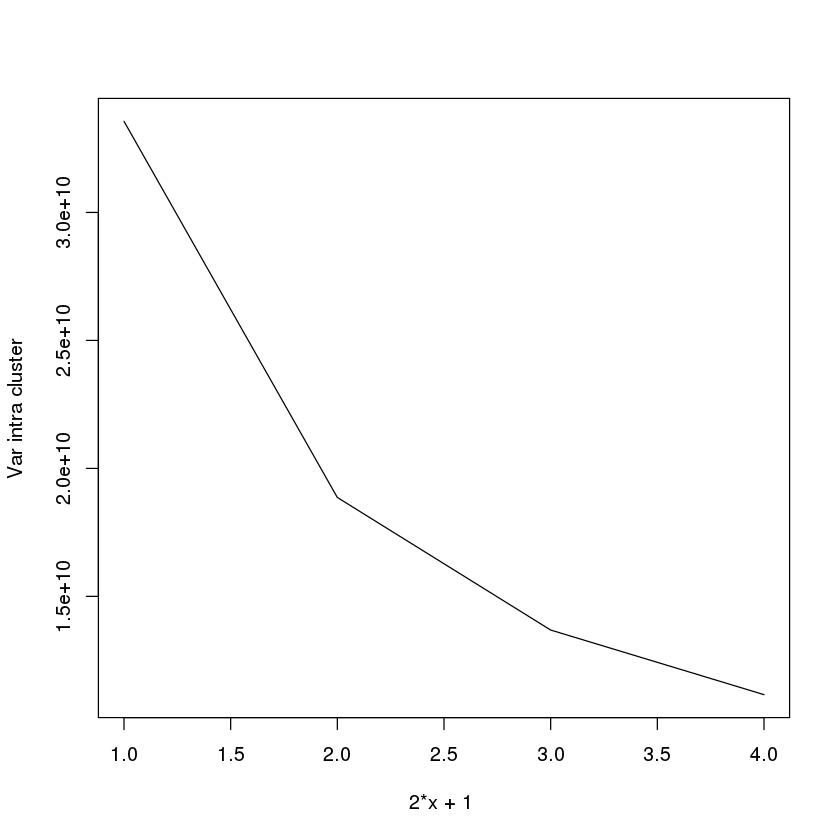

In [27]:
plot((cluster),type = 'l', xlab = '2*x + 1 ', ylab = 'Var intra cluster')

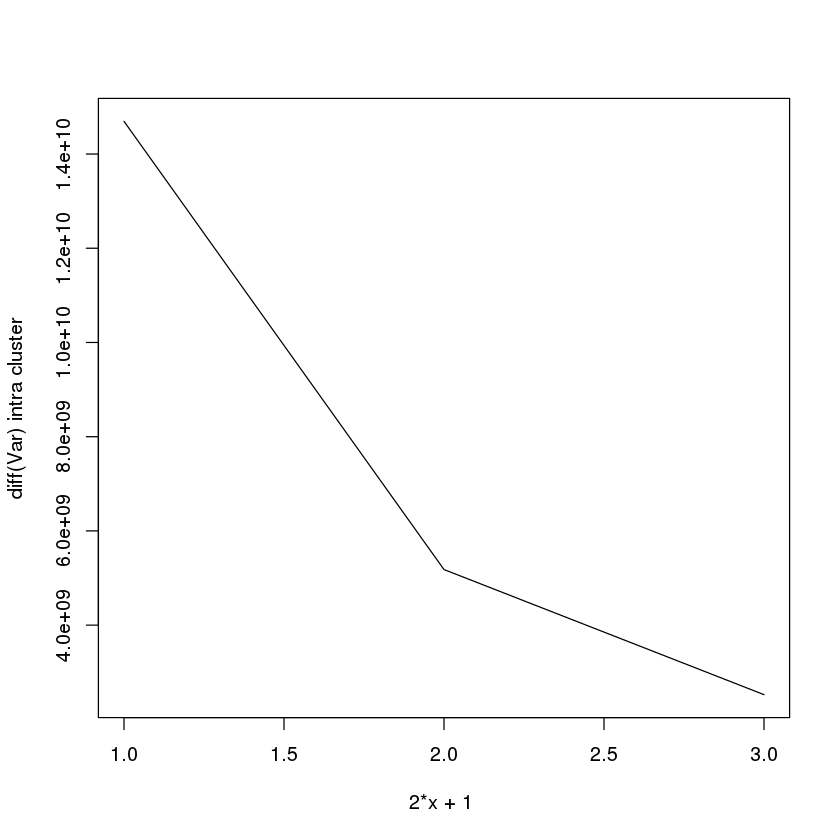

In [28]:
plot(abs(diff(cluster)),type = 'l',  xlab = '2*x + 1 ', ylab = 'diff(Var) intra cluster')

Por lo que consideramos que una elección de $k=7$ es adecuada y ejecutamos el algoritmo de kmeans online implementado sobre el conjunto completo de datos. 

In [29]:
k = 7

In [30]:
library(reshape2)
library(dplyr)
library(lubridate)
data <- read.csv('Fire_Department_Calls_for_Service.csv', stringsAsFactors = FALSE)
print(head(data))

data$RowID <- data$Unit.ID <- data$Incident.Number <- data$Location <- data$Unit.Type <- data$Unit.sequence.in.call.dispatch <- data$Call.Type <- NULL
data[ , c('Current.Police.Districts', 'Neighborhoods...Analysis.Boundaries', 'Zip.Codes', 'Neighborhoods..old.', 'Police.Districts', 
          'Civic.Center.Harm.Reduction.Project.Boundary', 'HSOC.Zones', 'Central.Market.Tenderloin.Boundary.Polygon...Updated')] <- NULL
data$Received.DtTm <- mdy_hms(data$Received.DtTm)
data %>% group_by(Call.Number ) %>% arrange(Call.Number , Received.DtTm ) %>% mutate( flag1 = n() ,flag2 = row_number()) -> data
data %>% filter(flag1 ==flag2 ) -> data
data$flag1 <- data$flag2 <- NULL
data$Available.DtTm <- NULL
data$Call.Date <- mdy(data$Call.Date)
data$Watch.Date <- mdy(data$Watch.Date)
data$Entry.DtTm <- mdy_hms(data$Entry.DtTm)
data$Dispatch.DtTm <- mdy_hms(data$Dispatch.DtTm)
data$Response.DtTm <- mdy_hms( data$Response.DtTm) 
data$On.Scene.DtTm <- mdy_hms( data$On.Scene.DtTm) 
data$Transport.DtTm <- mdy_hms(data$Transport.DtTm) 
data$Hospital.DtTm <- mdy_hms(data$Hospital.DtTm) 
data.t <- melt(data, id = c('Call.Number','Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 
                            'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 
                            'Number.of.Alarms',  'Fire.Prevention.District', 'Supervisor.District', 
                            'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts', 'Fire.Prevention.Districts' ) ) %>%
          filter( variable %in% c('Received.DtTm', 'Entry.DtTm', 'Dispatch.DtTm', 'Response.DtTm', 'On.Scene.DtTm', 'Transport.DtTm', 'Hospital.DtTm' )) 
data.t %>% group_by (Call.Number, Call.Final.Disposition, Address, City, Zipcode.of.Incident, Battalion, 
                            Station.Area, Box, Original.Priority, Priority, Final.Priority, ALS.Unit, Call.Type.Group, 
                            Number.of.Alarms,  Fire.Prevention.District, Supervisor.District, 
                            Neighborhooods...Analysis.Boundaries, Supervisor.Districts, Fire.Prevention.Districts  ) %>% 
      summarise( min.t = min(value, na.rm=TRUE), max.t =max(value, na.rm=TRUE)) -> data.t
data.t <- data.t %>% mutate(Call.seconds = max.t - min.t)
data.t$min.t <- data.t$max.t <- NULL 
data.t <- as.data.frame(data.t)

print(dim(data.t))
Y <- data.frame(y=data.t$Call.Type.Group)
row.names(Y) <- row.names(data.t) <- data.t$Call.Number
data.t$Call.Type.Group <- data.t$Call.Number <- NULL
# hacemos un cambio de encoding de las variables ordinales para no hacer una matriz con muchas variables ---IMPORTANTE
index <- which(is.na(Y$y))
Y$y <- as.character(Y$y) 
Y$y[index] <- 'No asignado'
index <- which(sapply(data.t, class) == 'character')

normalizar <- function(x, na.rm = FALSE) (x - mean(x, na.rm = na.rm)) / sd(x, na.rm)
# mas preprocesamiento de datos
for (i in index)
    {
    index.na <- which( is.na(data.t[, i] ))
    data.t[index.na, i] <- 'NULL'
    temp <- factor( data.t[, i])
    data.t[, i] <- normalizar(as.numeric( temp))
}
head(data.t)

  Call.Number Unit.ID Incident.Number        Call.Type  Call.Date Watch.Date
1   201560006      86        20064818 Medical Incident 06/04/2020 06/03/2020
2   201560006     E48        20064818 Medical Incident 06/04/2020 06/03/2020
3   201560006    RA48        20064818 Medical Incident 06/04/2020 06/03/2020
4   201560012      94        20064819 Medical Incident 06/04/2020 06/03/2020
5   201560019     E01        20064820     Outside Fire 06/04/2020 06/03/2020
6   201560029      53        20064821 Medical Incident 06/04/2020 06/03/2020
           Received.DtTm             Entry.DtTm          Dispatch.DtTm
1 06/04/2020 12:00:17 AM 06/04/2020 12:02:00 AM 06/04/2020 12:02:09 AM
2 06/04/2020 12:00:17 AM 06/04/2020 12:02:00 AM 06/04/2020 12:02:09 AM
3 06/04/2020 12:00:17 AM 06/04/2020 12:02:00 AM 06/04/2020 12:02:09 AM
4 06/04/2020 12:03:15 AM 06/04/2020 12:05:31 AM 06/04/2020 12:05:48 AM
5 06/04/2020 12:09:59 AM 06/04/2020 12:11:01 AM 06/04/2020 12:11:53 AM
6 06/04/2020 12:17:34 AM 06/04/2020

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`summarise()` regrouping output by 'Call.Number', 'Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 'Number.of.Alarms', 'Fire.Prevention.District', 'Supervisor.District', 'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts' (override with `.groups` argument)



[1] 2442878      20


,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,Final.Priority,ALS.Unit,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,Call.seconds
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1030101,0.9081488,-0.3832730,0.5983279,94116,1.0959416,0.01515439,-1.382416,0.2173244,0.3039489,3,0.7168879,1,1.4651812,-0.2072683,0.9777683,3,1,91
1030104,0.9081488,-0.6620982,0.5983279,94122,1.0959416,0.36411570,1.668121,0.2173244,0.3039489,3,0.7168879,1,1.4651812,-0.2072683,0.9777683,3,1,3271
1030106,0.9081488,-1.4591089,0.5983279,94102,-0.9415835,1.20162285,-0.530643,0.2173244,0.3039489,3,-1.3949177,1,-0.6850764,0.4911210,1.0532408,9,7,3622
1030107,0.9081488,-1.1769414,0.5983279,94102,-0.6019960,-1.17131407,-1.022259,0.2173244,0.3039489,3,-1.3949177,1,-0.3267001,0.4911210,1.0532408,9,14,329
1030108,0.9081488,0.6663387,0.5983279,94108,-0.6019960,-1.17131407,-1.119501,0.2173244,0.3039489,3,0.7168879,1,-1.4018289,-0.5564629,-1.2864096,10,5,2134
1030112,0.9081488,0.7646796,0.5983279,94109,-1.2811711,-1.03172954,-1.016856,0.2173244,0.3039489,3,-1.3949177,1,-1.4018289,-0.5564629,-0.1543207,10,5,359


In [31]:
1

[1] 1

In [32]:
alpha <- 0.1
t1 <- Sys.time()
tabla.master <- data.frame(Obs = row.names(data.t), Cluster= rep(-Inf, dim(data.t)[1]))
    # inicializacion alatoria entre el minimo y maximo de cada variable
head(tabla.master)

,Obs,Cluster
,<fct>,<dbl>
1,1030101,-Inf
2,1030104,-Inf
3,1030106,-Inf
4,1030107,-Inf
5,1030108,-Inf
6,1030112,-Inf


In [33]:
stats.min <- sapply(data.t, min, na.rm=TRUE)
stats.max <- sapply(data.t, max, na.rm=TRUE)
set.seed(0)
centroides <- mapply(function(x, y) {runif(k, x, y)},  stats.min, stats.max) 
    # termina inicializacion de centroides

# comienza kmeans proceso online
    for( i in 1:dim(data.t)[1])
    {
      if(i %% 100000 ==0 )
      print(i)
      # comienza asignacion de cluster mas cercano
      observacion.en.juego <- as.matrix(data.t[i, ])
      m.temp <- as.matrix(rbind(observacion.en.juego, centroides))
      distancias <- dist(m.temp)
      m.distancias <- as.matrix(distancias)
      k.i <- which.min(m.distancias[1, 2:(k+1)])
      tabla.master$Cluster[i] <- k.i
      # termina asignacion de cluster mas cercano 
      # update de cluster
      centroides[k.i, ] <- centroides[k.i, ] + alpha*observacion.en.juego
    }
t2 <- Sys.time()

[1] 100000
[1] 200000
[1] 300000
[1] 400000
[1] 500000
[1] 600000
[1] 700000
[1] 800000
[1] 900000
[1] 1000000
[1] 1100000
[1] 1200000
[1] 1300000
[1] 1400000
[1] 1500000
[1] 1600000
[1] 1700000
[1] 1800000
[1] 1900000
[1] 2000000
[1] 2100000
[1] 2200000
[1] 2300000
[1] 2400000


In [44]:
t2 - t1

Time difference of 6.454484 hours

In [45]:
index <- which(Y$y == '')
Y$y <- as.character(Y$y) 
Y$y[index] <- 'No asignado'

In [46]:
tabla.master$etiqueta.original <- Y$y

In [47]:
table(tabla.master$etiqueta.original, tabla.master$Cluster)

                              
                                    1      2      3      4      5      6      7
  Alarm                          4856  89670  88468   5102   4916   4952  25291
  Fire                            792  11599  11633    848    819    757   3804
  No asignado                   97676 374520 310971  93878  95194 118890 160748
  Non Life-threatening          38009  94026  93398  39577  39552  38906  58144
  Potentially Life-Threatening  36267 158199 157760  37490  37684  36297  72185

In [48]:
write.csv(tabla.master, file='resultados_cluster_7.csv')

# Conclusión 

Con la clasificación no supervisada resultado de kmeans online con 7 grupos, tenemos las siguientes observaciones:
   1. En relación a nuestra primera hipótesis sobre encontrar grupos de llamadas similares podemos establecer que efectivamente un $k=7$ es apropiado. En el notebook `JessVega-Copy2`repetimos el mismo ejercicio pero con una configuración diferente:
       a) En este set up el número de clusters se fijó a 5 un número que surge de manera intuitiva al considerar las 4 categorías que se encuentran en la data más la que está ausente (valor ullo). En este experimento el resultado está sumamente sesgado donde la mayoría de las llamadas son clasificadas al grupo 5. 

2. Sobre la segunda hipótesis podemos concluir con base en la tabla de frecuencias anterior que lo más verosímil es asignar a la etiqueta de los datos `Potentially Life-Threatening` el label 2, a la etiqueta de los datos `Non Life-threatening` el label 4, a la etiqueta de los datos `Fire` el label 7, a la etiqueta de los datos `Alarm` el label 3 y finalmente a todas las llamadas a las que no se les asignó una llamada podemos atribuirlas principalmente al grupo 2.   

Hay dos comentarios importantes finales. 
Si bien el número 7 de cluster pareciera ser grande su existencia se respalda porque las 5 etiquetas presentes en la data se distribuyen transversalmente en ellos. 
Por último la distribución de la etiqueta `No asignado` proporciona ideas de un futuro análisis para proponer una nueva clasificación con más de 7 niveles. 


In [49]:
1

[1] 1

In [50]:
1

[1] 1

In [51]:
1

[1] 1

In [52]:
1

[1] 1

In [53]:
1

[1] 1